Epoch     0 | Interior: 4.2212e-01 | Terminal: 8.2608e+02 | Neumann: 5.4220e-05 | Total: 8.2650e+02
Epoch  1000 | Interior: 2.7986e+00 | Terminal: 5.4245e+01 | Neumann: 1.0093e-01 | Total: 5.7144e+01
Epoch  2000 | Interior: 9.2528e-01 | Terminal: 9.7914e+00 | Neumann: 2.0068e-01 | Total: 1.0917e+01
Epoch  3000 | Interior: 4.5060e-01 | Terminal: 3.9549e+00 | Neumann: 2.2778e-01 | Total: 4.6333e+00
Epoch  4000 | Interior: 4.2040e-01 | Terminal: 8.7815e-01 | Neumann: 2.6625e-01 | Total: 1.5648e+00


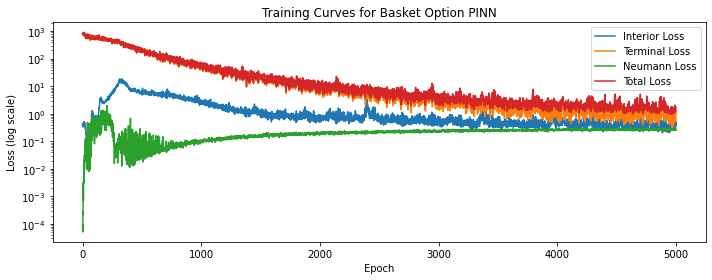

Terminal (t=T) MSE: 1.1019e+00


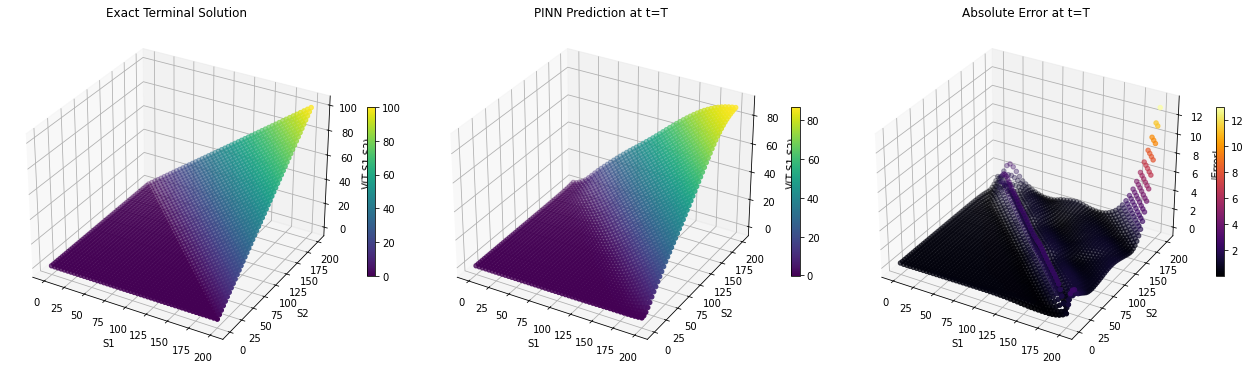

Terminal Boundary MSE: 9.7946e-01
Spatial Neumann MSE (approx): 2.9257e-03


In [2]:
"""
=====================================================================
      Two-Asset Black–Scholes PDE PINN Solver for a Basket Option
=====================================================================

Description:
------------
This script demonstrates how to solve a two-dimensional Black–Scholes
PDE for a European call option on a basket of two risky assets using a
Physics-Informed Neural Network (PINN) implemented in PyTorch.

The PDE is given by

  ∂V/∂t + 0.5σ₁²S₁²V₍ₛ₁₎₍ₛ₁₎ + 0.5σ₂²S₂²V₍ₛ₂₎₍ₛ₂₎ + ρσ₁σ₂S₁S₂V₍ₛ₁₎₍ₛ₂₎
        + rS₁V₍ₛ₁₎ + rS₂V₍ₛ₂₎ - rV = 0

on the truncated domain (t,S₁,S₂) ∈ [0,T]×[0,S_max]². We solve the PDE
backward in time, with terminal condition at t=T:

  V(T,S₁,S₂) = max(0.5S₁ + 0.5S₂ - K, 0).

Parameters:
  - T = 1.0 (time-to-maturity)
  - r = 0.05 (risk-free rate)
  - σ₁ = 0.2, σ₂ = 0.3 (volatilities)
  - ρ = 0.25 (correlation between S₁ and S₂)
  - Weights: w₁ = 0.5, w₂ = 0.5, strike K = 100
  - S₁, S₂ ∈ [0, S_max] with S_max = 200

Since asset prices are unbounded, we enforce homogeneous Neumann
(boundary derivative = 0) conditions on S₁ and S₂ at S=0 and S=S_max.

PINN Approach:
--------------
1. Define a feed-forward neural network that approximates V(t,S₁,S₂).
2. Use automatic differentiation (autograd) to compute first and
   second derivatives with respect to t, S₁, and S₂.
3. Define the PDE residual as
       r = V_t + 0.5σ₁²S₁²V₍ₛ₁₎₍ₛ₁₎ + 0.5σ₂²S₂²V₍ₛ₂₎₍ₛ₂₎ + ρσ₁σ₂S₁S₂V₍ₛ₁₎₍ₛ₂₎
           + rS₁V₍ₛ₁₎ + rS₂V₍ₛ₂₎ - rV.
4. Impose the terminal condition (at t=T) via a terminal loss.
5. Impose homogeneous Neumann conditions on the spatial boundaries via
   a Neumann loss.
6. The total loss is the sum of the interior (PDE) loss, terminal loss, and
   Neumann loss.
7. Train the network with Adam.
8. Evaluate the trained solution on a grid and produce 3D scatter plots
   of the terminal solution, along with error metrics.

Dependencies:
--------------
- torch (PyTorch)
- numpy
- matplotlib

Usage:
------
Run this script (e.g., via "python basket_pinn.py") after installing the
dependencies. It will train the PINN, plot training curves and 3D scatter plots,
and print interior and boundary errors.

=====================================================================
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) Problem Parameters
# ----------------------------
T = 1.0          # Maturity
r = 0.05         # Risk-free rate
sigma1 = 0.2     # Volatility of asset 1
sigma2 = 0.3     # Volatility of asset 2
rho = 0.25       # Correlation between asset 1 and asset 2
w1, w2 = 0.5, 0.5   # Weights in basket
K = 100          # Strike

S_max = 200      # Truncated domain for S1 and S2: [0, S_max]

# Terminal (payoff) function for the basket option
def terminal_payoff(S1, S2):
    payoff = w1 * S1 + w2 * S2 - K
    return torch.maximum(payoff, torch.tensor(0.0))

# ----------------------------
# 2) Neural Network Model
# ----------------------------
class PINN_BS(nn.Module):
    def __init__(self, layers=[3, 64, 64, 64, 1]):
        """
        Input: (t, S1, S2)
        Output: V(t,S1,S2)
        """
        super().__init__()
        self.activation = nn.Tanh()
        net = []
        for i in range(len(layers)-2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(nn.Tanh())
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*net)
    
    def forward(self, x):
        return self.model(x)

# ----------------------------
# 3) PDE Residual Function
# ----------------------------
def bs_pde_residual(model, t, S1, S2):
    """
    Compute the residual for the two-asset Black-Scholes PDE.
    Inputs t, S1, S2 must require gradients.
    """
    inp = torch.cat([t, S1, S2], dim=1)
    V = model(inp)

    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_S1 = torch.autograd.grad(V, S1, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_S2 = torch.autograd.grad(V, S2, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_S1S1 = torch.autograd.grad(V_S1, S1, grad_outputs=torch.ones_like(V_S1), create_graph=True)[0]
    V_S2S2 = torch.autograd.grad(V_S2, S2, grad_outputs=torch.ones_like(V_S2), create_graph=True)[0]
    V_S1S2 = torch.autograd.grad(V_S1, S2, grad_outputs=torch.ones_like(V_S1), create_graph=True)[0]
    
    # Black-Scholes PDE residual:
    res = V_t + 0.5 * sigma1**2 * S1**2 * V_S1S1 + 0.5 * sigma2**2 * S2**2 * V_S2S2 \
          + rho * sigma1 * sigma2 * S1 * S2 * V_S1S2 \
          + r * S1 * V_S1 + r * S2 * V_S2 - r * V
    return res

# ----------------------------
# 4) Loss Functions
# ----------------------------
def interior_loss(model, n_int=2000):
    """
    Sample interior points in (t,S1,S2) and compute PDE residual loss.
    t ∈ [0,T], S1,S2 ∈ [0,S_max]
    """
    t_int = torch.rand(n_int, 1) * T
    S1_int = torch.rand(n_int, 1) * S_max
    S2_int = torch.rand(n_int, 1) * S_max
    t_int.requires_grad_(True)
    S1_int.requires_grad_(True)
    S2_int.requires_grad_(True)
    
    res = bs_pde_residual(model, t_int, S1_int, S2_int)
    return torch.mean(res**2)

def terminal_loss(model, n_term=500):
    """
    Enforce terminal condition at t = T.
    """
    S1_term = torch.rand(n_term, 1) * S_max
    S2_term = torch.rand(n_term, 1) * S_max
    t_term = T * torch.ones_like(S1_term)
    
    inp = torch.cat([t_term, S1_term, S2_term], dim=1)
    V_pred = model(inp)
    V_true = terminal_payoff(S1_term, S2_term)
    return torch.mean((V_pred - V_true)**2)

def neumann_loss(model, n_neum=400):
    """
    Impose homogeneous Neumann conditions on the spatial boundaries.
    For each boundary: S1=0, S1=S_max, S2=0, S2=S_max.
    We force the derivative with respect to S1 or S2 to zero.
    """
    n_each = n_neum // 4
    
    # For S1=0, ensure ∂V/∂S1=0
    t_val = torch.rand(n_each, 1) * T
    S1_val = torch.zeros(n_each, 1, requires_grad=True)  # require grad here
    S2_val = torch.rand(n_each, 1) * S_max
    S2_val.requires_grad_(True)  # if needed for mixed derivative (but here not used)
    inp = torch.cat([t_val, S1_val, S2_val], dim=1)
    V = model(inp)
    dV_dS1 = torch.autograd.grad(V, S1_val, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    loss_S1_0 = torch.mean(dV_dS1**2)
    
    # For S1=S_max, ∂V/∂S1=0
    t_val = torch.rand(n_each, 1) * T
    S1_val = S_max * torch.ones(n_each, 1, requires_grad=True)
    S2_val = torch.rand(n_each, 1) * S_max
    inp = torch.cat([t_val, S1_val, S2_val], dim=1)
    V = model(inp)
    dV_dS1 = torch.autograd.grad(V, S1_val, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    loss_S1_max = torch.mean(dV_dS1**2)
    
    # For S2=0, ∂V/∂S2=0
    t_val = torch.rand(n_each, 1) * T
    S1_val = torch.rand(n_each, 1) * S_max
    S2_val = torch.zeros(n_each, 1, requires_grad=True)
    inp = torch.cat([t_val, S1_val, S2_val], dim=1)
    V = model(inp)
    dV_dS2 = torch.autograd.grad(V, S2_val, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    loss_S2_0 = torch.mean(dV_dS2**2)
    
    # For S2=S_max, ∂V/∂S2=0
    t_val = torch.rand(n_each, 1) * T
    S1_val = torch.rand(n_each, 1) * S_max
    S2_val = S_max * torch.ones(n_each, 1, requires_grad=True)
    inp = torch.cat([t_val, S1_val, S2_val], dim=1)
    V = model(inp)
    dV_dS2 = torch.autograd.grad(V, S2_val, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    loss_S2_max = torch.mean(dV_dS2**2)
    
    return loss_S1_0 + loss_S1_max + loss_S2_0 + loss_S2_max

# ----------------------------
# 5) Training Loop
# ----------------------------
def train_pinn_bs(num_epochs=5000, lr=1e-3, print_every=1000):
    """
    Train the PINN to solve the two-asset Black-Scholes PDE.
    Total loss = Interior loss + Terminal loss + Neumann loss.
    """
    model = PINN_BS(layers=[3, 64, 64, 64, 1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    losses_interior = []
    losses_terminal = []
    losses_neumann = []
    losses_total = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss_int = interior_loss(model, n_int=2000)
        loss_term = terminal_loss(model, n_term=500)
        loss_neum = neumann_loss(model, n_neum=400)
        
        loss = loss_int + loss_term + loss_neum
        loss.backward()
        optimizer.step()
        
        losses_interior.append(loss_int.item())
        losses_terminal.append(loss_term.item())
        losses_neumann.append(loss_neum.item())
        losses_total.append(loss.item())
        
        if epoch % print_every == 0:
            print(f"Epoch {epoch:5d} | Interior: {loss_int.item():.4e} | Terminal: {loss_term.item():.4e} | Neumann: {loss_neum.item():.4e} | Total: {loss.item():.4e}")
    
    return model, losses_interior, losses_terminal, losses_neumann, losses_total

# ----------------------------
# 6) Train the Model
# ----------------------------
model_bs, li, lt, ln, ltot = train_pinn_bs(num_epochs=5000, lr=1e-3)

# ----------------------------
# 7) Plot Training Curves
# ----------------------------
plt.figure(figsize=(10,4))
plt.plot(li, label='Interior Loss')
plt.plot(lt, label='Terminal Loss')
plt.plot(ln, label='Neumann Loss')
plt.plot(ltot, label='Total Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Curves for Basket Option PINN')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 8) Evaluate the Learned Solution
# ----------------------------
N_test = 50
t_vals = np.linspace(0, T, N_test)
S1_vals = np.linspace(0, S_max, N_test)
S2_vals = np.linspace(0, S_max, N_test)
T_grid, S1_grid, S2_grid = np.meshgrid(t_vals, S1_vals, S2_vals, indexing='ij')
# Reshape into (N_test^3, 3)
inp_np = np.stack([T_grid.ravel(), S1_grid.ravel(), S2_grid.ravel()], axis=1)
inp_torch = torch.tensor(inp_np, dtype=torch.float)

with torch.no_grad():
    V_pred = model_bs(inp_torch).numpy().reshape(N_test, N_test, N_test)

# Evaluate at terminal time: t = T
V_pred_terminal = V_pred[-1,:,:]  # shape (N_test, N_test)
S1_grid_terminal = S1_grid[-1,:,:]
S2_grid_terminal = S2_grid[-1,:,:]
V_exact_terminal = np.maximum(w1 * S1_grid_terminal + w2 * S2_grid_terminal - K, 0.0)

mse_terminal = np.mean((V_pred_terminal - V_exact_terminal)**2)
print(f"Terminal (t=T) MSE: {mse_terminal:.4e}")

# ----------------------------
# 9) 3D Scatter Plots at Terminal Time
# ----------------------------
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18,5))

# Scatter plot of the exact terminal solution
ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(S1_grid_terminal, S2_grid_terminal, V_exact_terminal, c=V_exact_terminal, cmap='viridis')
ax1.set_title("Exact Terminal Solution")
ax1.set_xlabel("S1")
ax1.set_ylabel("S2")
ax1.set_zlabel("V(T,S1,S2)")
plt.colorbar(sc1, ax=ax1, shrink=0.5)

# Scatter plot of the PINN prediction at terminal time
ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(S1_grid_terminal, S2_grid_terminal, V_pred_terminal, c=V_pred_terminal, cmap='viridis')
ax2.set_title("PINN Prediction at t=T")
ax2.set_xlabel("S1")
ax2.set_ylabel("S2")
ax2.set_zlabel("V(T,S1,S2)")
plt.colorbar(sc2, ax=ax2, shrink=0.5)

# Scatter plot of the absolute error at terminal time
abs_error = np.abs(V_pred_terminal - V_exact_terminal)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(S1_grid_terminal, S2_grid_terminal, abs_error, c=abs_error, cmap='inferno')
ax3.set_title("Absolute Error at t=T")
ax3.set_xlabel("S1")
ax3.set_ylabel("S2")
ax3.set_zlabel("|Error|")
plt.colorbar(sc3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

# ----------------------------
# 10) Evaluate Boundary Errors
# ----------------------------
def bs_boundary_mse(model, n_points=100):
    # Evaluate terminal boundary along S1,S2 at t=T
    S1_line = np.linspace(0, S_max, n_points)
    S2_line = np.linspace(0, S_max, n_points)
    S1_line, S2_line = np.meshgrid(S1_line, S2_line, indexing='ij')
    S1_line = S1_line.ravel()[:,None]
    S2_line = S2_line.ravel()[:,None]
    t_term = T * np.ones_like(S1_line)
    inp = torch.tensor(np.hstack([t_term, S1_line, S2_line]), dtype=torch.float)
    with torch.no_grad():
        V_term_pred = model(inp).numpy().ravel()
    V_term_exact = np.maximum(w1 * S1_line.ravel() + w2 * S2_line.ravel() - K, 0)
    err_term = np.mean((V_term_pred - V_term_exact)**2)
    
    # For spatial boundaries: we check the Neumann condition (∂V/∂S1=0 or ∂V/∂S2=0)
    # Example for S1=0:
    t_val = torch.rand(n_points, 1) * T
    S1_val = torch.zeros(n_points, 1, requires_grad=True)
    S2_val = torch.rand(n_points, 1) * S_max
    inp = torch.cat([t_val, S1_val, S2_val], dim=1)
    V_val = model(inp)
    dV_dS1 = torch.autograd.grad(V_val, S1_val, grad_outputs=torch.ones_like(V_val), create_graph=True)[0]
    err_S1_0 = torch.mean(dV_dS1**2).item()
    
    # We return both terminal loss and the Neumann error (average over boundaries could be computed)
    return err_term, err_S1_0

err_term, err_neum = bs_boundary_mse(model_bs)
print(f"Terminal Boundary MSE: {err_term:.4e}")
print(f"Spatial Neumann MSE (approx): {err_neum:.4e}")
